In [441]:
import networkx as nx
from networkx.algorithms import community
import matplotlib.pyplot as plt
import random
import itertools

%matplotlib inline

In [482]:
def girvan_newman(G):
    """Returns an iterator over tuples of sets of nodes, and the edges that have been removed
    Each set is a community; each tuple is all the communities at one step in the algorithm
    """
    if G.number_of_edges() == 0:
        return
    
    g = G.copy().to_undirected()
    g.remove_edges_from(nx.selfloop_edges(g))

    edges_removed = []
    while g.number_of_edges() > 0:
        yield _without_max_betweenness_edges(g, edges_removed)

def _without_max_betweenness_edges(G, edges_removed):
    num_components = nx.number_connected_components(G)
    num_new_components = num_components

    while num_new_components <= num_components:
        betweenness = nx.edge_betweenness_centrality(G)
        edges = max(betweenness, key=betweenness.get)

        G.remove_edge(*edges)
        edges_removed.append(edges)
    
        new_components = tuple(nx.connected_components(G))
        num_new_components = len(new_components)

    return new_components, list(edges_removed)

In [602]:
def build_test_graph(z_in, z_out, num_groups=4, group_size=32):
    """Return a test graph of random equal sized community groups

    Parameters:
    -----------
    z_in -- average number of edges from a node to nodes in the same community
    z_out -- average number of edges from a node to nodes in other communities
    """
    # Create groups and edges within groups
    groups = []
    p_in = z_in / (group_size - 1)
    for i in range(num_groups):
        group = nx.erdos_renyi_graph(group_size, p_in)
        nx.set_node_attributes(group, dict([(node, i) for node in group.nodes()]), 'group_id')
        groups.append(group)

    G = nx.disjoint_union_all(groups)

    # Create edges between groups
    p_out = z_out / ((num_groups - 1) * group_size)
    edges = itertools.combinations(G.nodes(), 2)
    for i, j in edges:
        if G.node[i]['group_id'] != G.node[j]['group_id'] and random.random() < p_out:
            G.add_edge(i, j)

    return G

def calc_test_result(G, partitions, num_groups=4):
    """Return the ratio of correctly classified nodes over the total number of nodes.
    Assumes the nodes in G are labeled based on their community.
    """
    best_num_correct_nodes = 0
    for perm in itertools.permutations(partitions, num_groups):
        num_correct_nodes = 0
        group_id = 0

        for group in perm:
            for node in group:
                if G.node[node]['group_id'] == group_id:
                    num_correct_nodes += 1
            group_id += 1

        if num_correct_nodes > best_num_correct_nodes:
            best_num_correct_nodes = num_correct_nodes

    return best_num_correct_nodes / len(G.nodes())

def plot_test_results(initial_z_out, final_z_out, max_z_out=16, step_size=0.5):
    z_out = initial_z_out

    result = {}
    while z_out < final_z_out:
        G = build_test_graph(max_z_out - z_out, z_out)

        communityIter = girvan_newman(G)
        partition, removed_edges = max(communityIter,
                                       key=lambda c: community.modularity(G, c[0]))

        result[z_out] = 100 * calc_test_result(G, partition)

        a = [val for n, val in G.degree()]
        print(z_out, result[z_out], sum(a) / len(a), str(len(partition)))

        z_out += step_size
        
    plt.title('Accuracy of Community Detection', fontsize=14)
    plt.xlabel('Avg Out-Degree', fontsize=12)
    plt.ylabel('% of Correct Nodes', fontsize=12)
    plt.autoscale()
    plt.plot(list(result.keys()), list(result.values()), 'bo--', linewidth=1)

def plot_communities(gml_file=None):
    if gml_file:
        G = nx.read_graphml(gml_file)
    else:
        G = build_test_graph(15, 1)
 
    communityIter = girvan_newman(G)
    partition, removed_edges = max(communityIter,
                                   key=lambda c: community.modularity(G, c[0]))
    pos=nx.spring_layout(G, weight=None, iterations=100)

    colors = ['violet','orange','cyan','yellow','pink','green','red','gray','blue', 'black', 'indigo']
    for i in range(len(partition)):
        nx.draw_networkx_nodes(G, pos, nodelist=list(partition[i]), node_color=colors[i], alpha=0.75)
    nx.draw_networkx_edges(G, pos, edgelist=list(set(G.edges() - set(removed_edges))))
    nx.draw_networkx_edges(G, pos, edgelist=removed_edges, edge_color='gray', style='dashed')
    # nx.draw_networkx_labels(G, pos, font_size=8)

    plt.title('Communities Found using Girvan-Newman', fontsize=14)
    plt.axis('off')
    # plt.savefig('output.jpg')

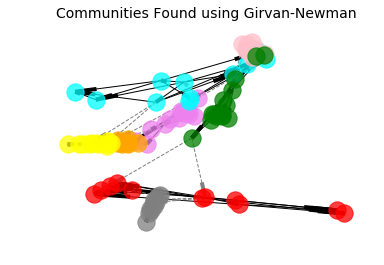

In [605]:
plot_communities('protein_structure.graphml')

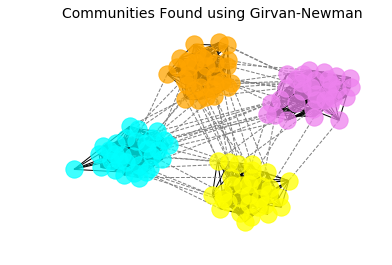

In [604]:
plot_communities()

15.328125 1 100.0
partition size: 4
16.328125 1.5 100.0
partition size: 4
17.03125 2.0 100.0
partition size: 4
16.3125 2.5 100.0
partition size: 4
15.59375 3.0 100.0
partition size: 4
16.03125 3.5 100.0
partition size: 4
16.21875 4.0 100.0
partition size: 4
15.5 4.5 99.21875
partition size: 4
15.9375 5.0 99.21875
partition size: 5
16.265625 5.5 100.0
partition size: 4
16.328125 6.0 96.875
partition size: 4
16.4375 6.5 71.875
partition size: 27
15.671875 7.0 66.40625
partition size: 32
15.34375 7.5 49.21875
partition size: 48
16.15625 8.0 42.1875
partition size: 49
15.078125 8.5 28.125
partition size: 65
16.171875 9.0 34.375
partition size: 44
15.640625 9.5 14.84375
partition size: 74
15.40625 10.0 14.84375
partition size: 83
15.890625 10.5 12.5
partition size: 81
16.453125 11.0 16.40625
partition size: 70
15.984375 11.5 14.0625
partition size: 77
16.546875 12.0 15.625
partition size: 71
15.96875 12.5 13.28125
partition size: 69
16.734375 13.0 16.40625
partition size: 76
15.890625 13.5 

{1: 100.0,
 1.5: 100.0,
 2.0: 100.0,
 2.5: 100.0,
 3.0: 100.0,
 3.5: 100.0,
 4.0: 100.0,
 4.5: 99.21875,
 5.0: 99.21875,
 5.5: 100.0,
 6.0: 96.875,
 6.5: 71.875,
 7.0: 66.40625,
 7.5: 49.21875,
 8.0: 42.1875,
 8.5: 28.125,
 9.0: 34.375,
 9.5: 14.84375,
 10.0: 14.84375,
 10.5: 12.5,
 11.0: 16.40625,
 11.5: 14.0625,
 12.0: 15.625,
 12.5: 13.28125,
 13.0: 16.40625,
 13.5: 12.5,
 14.0: 14.84375,
 14.5: 13.28125}

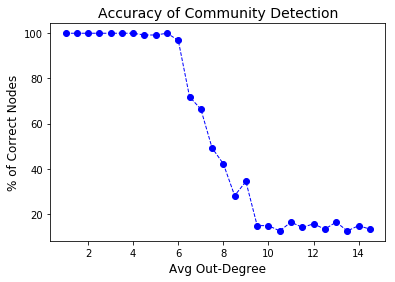

In [400]:
plot_test_results(4, 15, step_size=0.5)